# Бизнес-применение машинного обучения. ДЗ 2
## Николаев А.М.

### Подготовка

#### Библиотеки

In [ ]:
from scipy import stats
from statsmodels.stats.api import DescrStatsW
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import proportions_ztest
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Загрузка данных

In [36]:
df = pd.read_csv(r'./marketing_AB.csv', index_col=0)

#### Первый взгляд на датасет и предобработка

In [20]:
#report = ProfileReport(df, title='Marketing_AB_Data')
#report.to_file("marketing_ab_report.html")

Данная библиотека `ydata_profiling` позволяет создать бистрый интерактивный отчёт, файл прикреплён в репозитории.

Ниже описаны наблюдения по датасету:

- Пропущенных значений не наблюдается
- Дубликатов в `user_id` не наблюдается
- Столбцы `converted` и `test group` имеют дисбаланс (~4/5 ~3/4)
- Столбец `test_group` требует преобразования в категориальный тип
- Не вооружённым взглядом (не будем строить боксплот, так как по перцентилям и гистограмме видны выбросы) можно наблюдать в аномальные значения в столбце `total ads`. Обрежем их по перцентиля. Наблюдений у нас достаточно, существенно на результатах уменьшение выборки сказаться не должно. В описании задания не сказано в течении какого времени проводилось исследование, но >2000 показов вызывает сомнение и больше похоже на поведение "ботов".

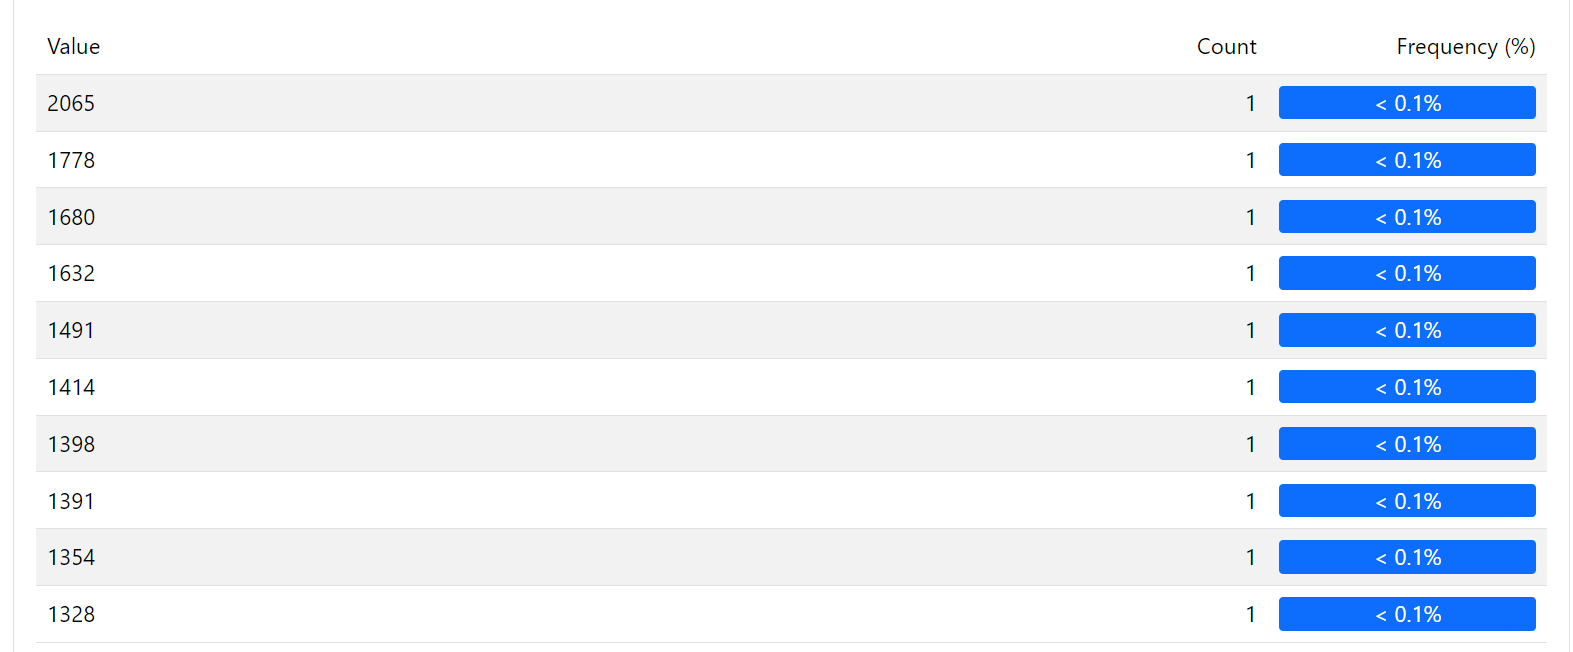
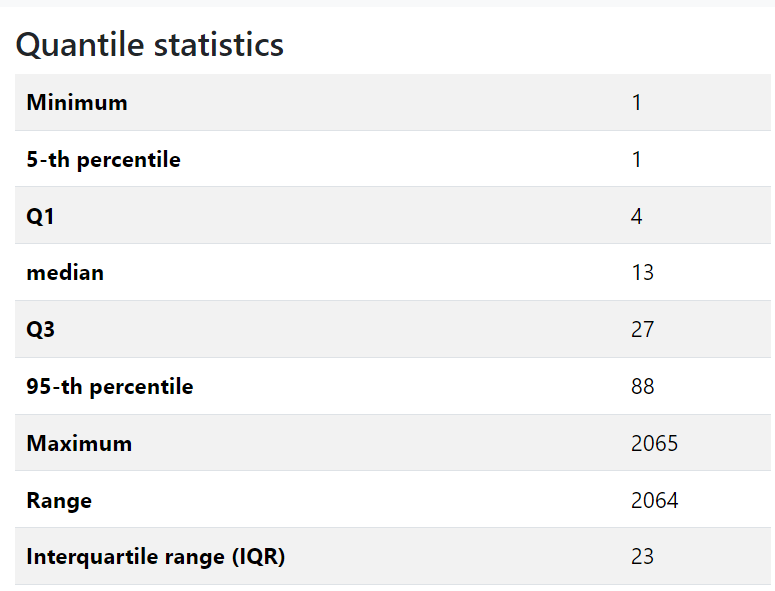
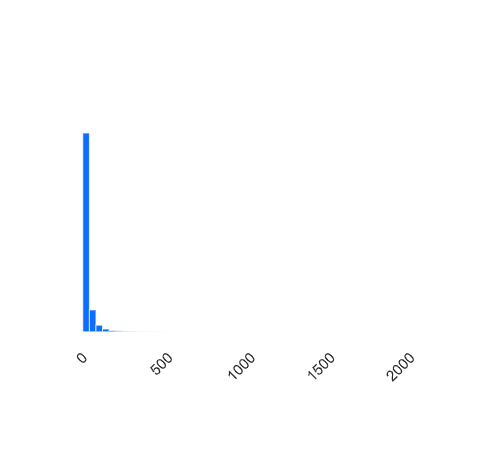

In [37]:
p_99 = df['total ads'].quantile(0.99)

# Удаление данных выше 99-го перцентиля
df = df[df['total ads'] <= p_99]

In [38]:
df['test group'] = df['test group'].astype('category')

Посмотрим на доли покупателей в разных группах (ad и psa)

In [23]:
conversion_by_group = df.groupby('test group')['converted'].agg(['count', 'sum', 'mean'])
conversion_by_group.columns = ['Всего в группе', 'Покупатели', 'Конверсия']
print(conversion_by_group)

            Всего в группе  Покупатели  Конверсия
test group                                       
ad                  559017       13554   0.024246
psa                  23274         380   0.016327


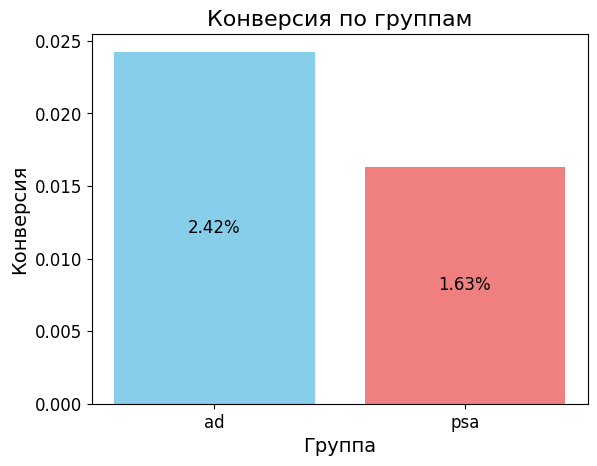

In [24]:
%matplotlib inline
plt.bar(conversion_by_group.index, conversion_by_group['Конверсия'], color=['skyblue', 'lightcoral'])

for index, value in enumerate(conversion_by_group['Конверсия']):
    plt.text(index, value / 2, f'{value:.2%}', ha='center', va='center', fontsize=12, color='black')

plt.title('Конверсия по группам', fontsize=16)
plt.xlabel('Группа', fontsize=14)
plt.ylabel('Конверсия', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Видно что конверсия в процентом соотношении отличается от группы к группе.
Теперь посмотрим на количество показов рекламы в этих 2-ух  и среднее количество показов.

            Количество показов  Среднее количество показов
test group                                                
ad                      559017                   21.814025
psa                      23274                   21.738249


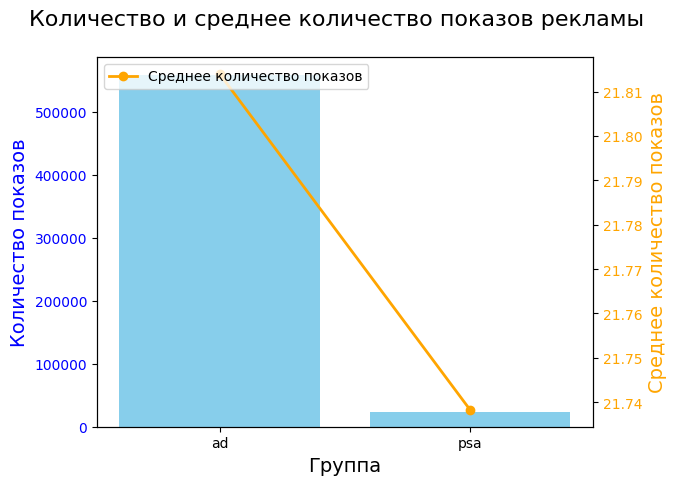

In [25]:

# Группировка данных по тестовым группам и расчет количества и среднего числа показов рекламы
stat = df.groupby('test group')['total ads'].agg(['count', 'mean'])

# Переименуем столбцы для удобства
stat.columns = ['Количество показов', 'Среднее количество показов']

# Выводим результаты
print(stat)
groups = stat.index
count_ads = stat['Количество показов']
mean_ads = stat['Среднее количество показов']

# Создание фигуры
fig, ax1 = plt.subplots()

# Построение столбцов для количества показов
ax1.bar(groups, count_ads, color='skyblue', label='Количество показов')
ax1.set_xlabel('Группа', fontsize=14)
ax1.set_ylabel('Количество показов', color='blue', fontsize=14)

# Добавление второй оси для среднего количества показов
ax2 = ax1.twinx()
ax2.plot(groups, mean_ads, color='orange', marker='o', label='Среднее количество показов', linewidth=2)
ax2.set_ylabel('Среднее количество показов', color='orange', fontsize=14)

# Настройка графика
fig.suptitle('Количество и среднее количество показов рекламы', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')
plt.xticks(fontsize=12)
plt.legend(loc='upper left')

# Показ графика
plt.show()

Видно, что среднее количество показов в группах отличается совсем незначительно, что свидетельствует об относительной сбалансированности групп по количеству показов.

#### Тесты

Пришло время составить несколько гипотез и проверить их гипотезами.
Для этого обратимся к вопросам от бизнеса:

- Была ли кампания успешной? Конечно на этот вопрос хочется ответить, учитатывая такие метрики, как lifetime value и CPC, чтобы понять, насколько больший капитал привлечёт кампания в сравнении с затратами на привлечение клиентов, но у нас нет этих данных, поэтому будем исходить из того, что нам известно. Гипотеза: между конверсиями рассматриваемых групп (psa, ad) при переходе в качество покупателей нет статистической разницы. Для проверки будем использовать z-тест для пропорций.
- Если кампания была успешной, насколько этот успех можно объяснить рекламой? Этот вопрос скорее относится к сравнительному анализу. Попробуем ответить на него через отношение конверсий, если обнаружим статичтическую разницу.
- Кроме того, по заданию на платформе нам необходимо также узнать есть ли статистическая разница между средними количествами увиденной рекламы в группах. Гипотеза: между средними количествами увиденной рекламы в группах есть статистическая разница. Для проверки будем использовать тест Манна Уитни.


In [26]:
def conv_test(df):
    ad_conv_cnt = df[df['test group'] == 'ad']['converted'].sum()
    ad_total = len(df[df['test group'] == 'ad'])
    psa_conv_cnt = df[df['test group'] == 'psa']['converted'].sum()
    psa_total = len(df[df['test group'] == 'psa'])

    stat, p_value = proportions_ztest([ad_conv_cnt, psa_conv_cnt], [ad_total, psa_total], alternative='two-sided')
    return stat, p_value

stat_conv, p_value_conv = conv_test(df)

print(f"Тест для конверсий. p-value = {p_value_conv:.8f}")


Тест для конверсий. p-value = 0.00000000


Проверку на нормальность распределения мы не делаем, поскольку, ссылаясь на ЦПТ и возможность использования случайной выборки из генеральной совокупности, мы утверждаем, что получим нормальное распределение. При использовании z-теста нулевая гипотеза отрицательна, p-value ~=0, то есть вероятность получить наблюдаемые значения выборок, при условии что между конверсиями групп нет статистической разницы крайне мала. 

Соответственно, мы можем сделать вывод о том, что между конверсиями рассматриваемых групп при переходе в качество покупателей есть статистической разница.

Отлично, отвечая на бизнес вопрос "Была ли кампания успешной?", да, кампания показала статистически значимую разницу при сравнении конверсии в покупателей среди групп. То есть кампания оказала влияние на различие в конверсиях.

"Если кампания была успешной, насколько этот успех можно объяснить рекламой?".

Сравниваем: 2.42-1.63/2.42 ~=33% То есть, конверсия тех клиентов, которые видели РК, выросла на 33% относительно тех, кто не видел РК.

In [31]:
stat_ads, p_value_ads = stats.mannwhitneyu(
    df[df['test group'] == 'ad']['total ads'], df[df['test group'] == 'psa']['total ads'], alternative='two-sided')

print(f"Тест для количества рекламы. p-value = {p_value_ads:.8f}")

Тест для количества рекламы. p-value = 0.00000000


Тест Манна Уитни показал, что изначальная схожесть количества средних показов в группах не подтвердилось. Есть статистическая разница в среднем количестве показа рекламы в группах.

Построим также доверительные интервалы для конверсий и средних количеством увиденной рекламы в группах.

In [ ]:
def ci_prop(success, total):
    ci = proportion_confint(success, total, alpha=0.05, method='wilson')
    return ci

ad_ci = ci_prop(
    df[df['test group'] == 'ad']['converted'].sum(),
    len(df[df['test group'] == 'ad'])
)
psa_ci = ci_prop(
    df[df['test group'] == 'psa']['converted'].sum(),
    len(df[df['test group'] == 'psa'])
)

print("\nДоверительные интервалы для конверсий:")
print(f"Группа ad: [{ad_ci[0]:.4f}, {ad_ci[1]:.4f}]")
print(f"Группа psa: [{psa_ci[0]:.4f}, {psa_ci[1]:.4f}]")

def ci_mean(data, alpha=0.05):
    # Используем DescrStatsW для расчета доверительного интервала для среднего
    stats = DescrStatsW(data)
    return stats.tconfint_mean(alpha=alpha)

# Для каждой группы рассчитываем доверительный интервал для среднего количества рекламы
ad_data = df[df['test group'] == 'ad']['total ads']
psa_data = df[df['test group'] == 'psa']['total ads']

ad_ci = ci_mean(ad_data)
psa_ci = ci_mean(psa_data)

print("\nДоверительные интервалы для среднего количества рекламы:")
print(f"Группа ad: [{ad_ci[0]:.4f}, {ad_ci[1]:.4f}]")
print(f"Группа psa: [{psa_ci[0]:.4f}, {psa_ci[1]:.4f}]")



Доверительные интервалы для конверсий:
Группа ad: [0.0238, 0.0247]
Группа psa: [0.0148, 0.0180]

Доверительные интервалы для среднего количества рекламы:
Группа ad: [21.7405, 21.8876]
Группа psa: [21.3621, 22.1144]


Доверительные интервалы не пересекаются, что также подтвердает наши теории.